In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp  #Gives access to the ODE integration package

In [13]:
from climlab.utils.thermo import pseudoadiabat

def generate_idealized_temp_profile(SST, plevs, Tstrat=200):
    """
    Generates an idealized temperature profile with specified SST and Tstrat
    """
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

def make_idealized_column(SST, num_lev=100, Tstrat=200):
    # Set up a column state
    state = climlab.column_state(num_lev=num_lev, num_lat=1)
    # Extract the pressure levels
    plevs = state['Tatm'].domain.axes['lev'].points
    # Set the SST
    state['Ts'][:] = SST
    # Set the atmospheric profile to be our idealized profile
    state['Tatm'][:] = generate_idealized_temp_profile(SST=SST, plevs=plevs, Tstrat=Tstrat)
    return state

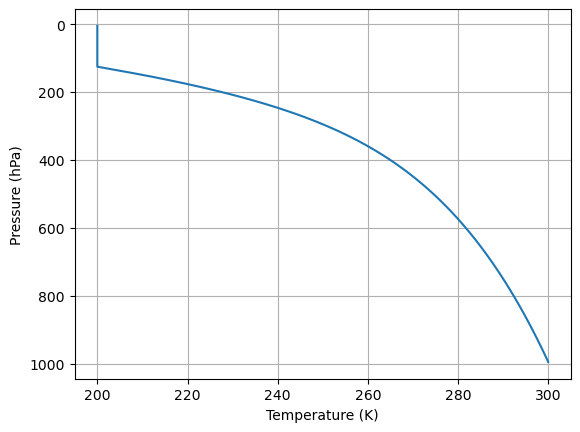

In [15]:
state = make_idealized_column(300)

# Plot the profile
fig, ax = plt.subplots(dpi=100)

state['Tatm'].to_xarray().plot(ax=ax, y='lev', yincrease=False)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (hPa)")
ax.grid()

In [16]:
h2o = climlab.radiation.water_vapor.ManabeWaterVapor(state=state,
                                                     relative_humidity=0.8)

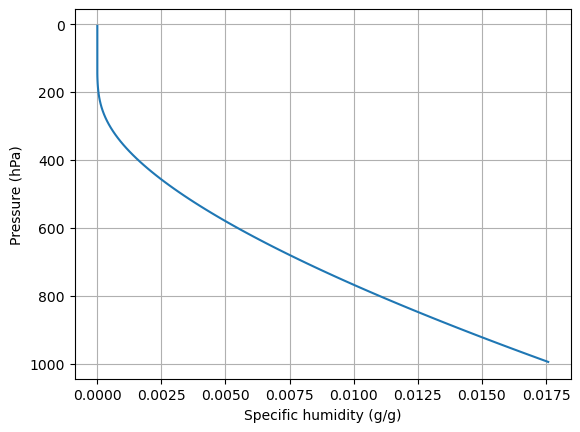

In [17]:
fig, ax = plt.subplots(dpi=100)

h2o.q.to_xarray().plot(ax=ax, y='lev', yincrease=False)

ax.set_xlabel("Specific humidity (g/g)")
ax.set_ylabel("Pressure (hPa)")
ax.grid()

In [18]:
absorber_vmr = {'CO2':280/1e6,
                'CH4':0.,
                'N2O':0.,
                'O2':0.,
                'CFC11':0.,
                'CFC12':0.,
                'CFC22':0.,
                'CCL4':0.,
                'O3':0.}


# RRTMG radiation
rad_lw = climlab.radiation.RRTMG_LW(state=state, specific_humidity=h2o.q,
                                 icld=0, # Clear-sky only!
                                 return_spectral_olr=False, # Just return total OLR
                                 absorber_vmr = absorber_vmr)
rad_lw.compute_diagnostics()

rad_SW = climlab.radiation.RRTMG_SW(state=state, specific_humidity=h2o.q,
                                 icld=0, # Clear-sky only!
                                 return_spectral_olr=False, # Just return total OLR
                                 absorber_vmr = absorber_vmr)
rad_SW.compute_diagnostics()

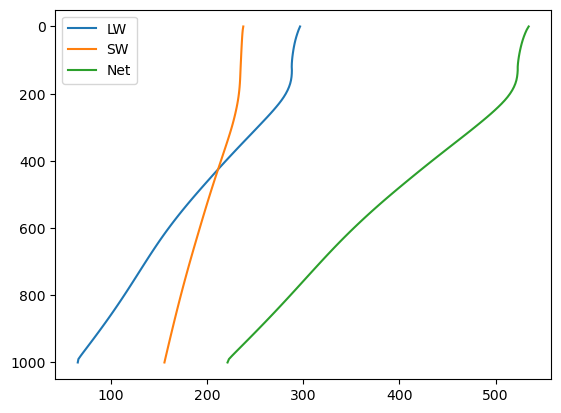

In [93]:
plt.plot(rad_lw.LW_flux_net, rad_lw.lev_bounds, label='LW')
plt.plot(rad_SW.SW_flux_net, rad_SW.lev_bounds, label='SW')
plt.plot(rad_lw.LW_flux_net+rad_SW.SW_flux_net, rad_lw.lev_bounds, label='Net')
plt.gca().invert_yaxis()

plt.legend()

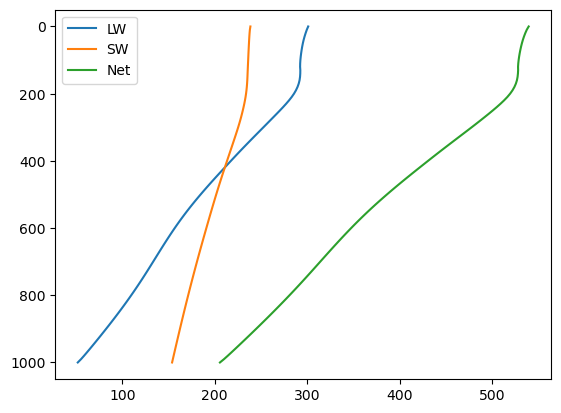

In [7]:
plt.plot(rad_lw.LW_flux_net, rad_lw.lev_bounds, label='LW')
plt.plot(rad_SW.SW_flux_net, rad_SW.lev_bounds, label='SW')
plt.plot(rad_lw.LW_flux_net+rad_SW.SW_flux_net, rad_lw.lev_bounds, label='Net')
plt.gca().invert_yaxis()
plt.legend()

In [7]:
rad.compute_diagnostics()
rad.OLR

Field([301.06657198])

In [8]:
def calc_olr(SST, CO2ppmv, return_spectral_olr=False, RH=0.8, Tstrat=200, qStrat=5e-06):
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = make_idealized_column(SST, Tstrat=Tstrat)

    #  fixed relative humidity
    #  Note we pass the qStrat parameter here, which sets a minimum specific humidity
    #  Set RH=0. and qStrat=0. for fully dry column
    h2o = climlab.radiation.water_vapor.ManabeWaterVapor(state=state,
                                                         relative_humidity=RH,
                                                         qStrat=qStrat,
                                                        )

    absorber_vmr['CO2'] = CO2ppmv/1e6

    # RRTMG radiation
    rad = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=h2o.q,
                                                   icld=0, # Clear-sky only!
                                                   return_spectral_olr=return_spectral_olr,
                                                   absorber_vmr = absorber_vmr)
    rad.compute_diagnostics()

    return rad

In [9]:
# Test this gives the same as before...
calc_olr(SST=300, CO2ppmv=280).OLR

Field([301.06657198])

In [10]:
%%time

n=20

OLRS = np.zeros((n,n))
temparray = np.linspace(280, 290, n)
co2array = np.linspace(280, 1200, n)

for idx1, temp in enumerate(temparray):
    for idx2, co2 in enumerate(co2array):
        OLRS[idx1, idx2] = calc_olr(temp, co2).OLR

CPU times: user 5.43 s, sys: 140 ms, total: 5.57 s
Wall time: 5.57 s


Text(0, 0.5, 'SST (K)')

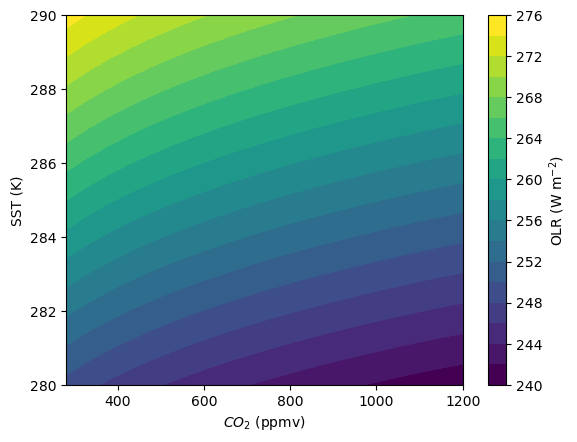

In [11]:
da = xr.DataArray(OLRS, dims=['temp', 'co2'],
                  coords={'temp':temparray,
                          'co2':co2array},
                 )

fig, ax = plt.subplots(dpi=100)

p = da.plot.contourf(ax=ax,
                     cmap='viridis',
                     levels=20,
                     add_colorbar=False)

fig.colorbar(p, label="OLR (W m$^{-2}$)")

ax.set_xlabel("$CO_{2}$ (ppmv)")
ax.set_ylabel("SST (K)")

In [12]:
# To do this, we'll run the model with the idealized temperature profile
# but not include the effects of water vapour (i.e., set RH=0 and qStrat=0)

# We've already set all other absorbing species to 0.

rad1 = calc_olr(SST=300, CO2ppmv=0., RH=0., return_spectral_olr=True, qStrat=0.)

In [13]:
# check that the different OLRs match up...

print(rad1.OLR_spectral.to_xarray().sum('wavenumber').values)

print(rad1.OLR)

[454.81611717]
[454.87164075]


In [14]:
wavenumbers = np.linspace(0.1, 3000) # don't start from zero to avoid divide by zero warnings

# Centers and Widths of the spectral bands, cm-1
spectral_centers = rad1.OLR_spectral.domain.axes['wavenumber'].points
spectral_widths = rad1.OLR_spectral.domain.axes['wavenumber'].delta

def planck_curve(wavenumber, T):
    '''Return the Planck curve in units of W/m2/cm-1
    Inputs: wavenumber in cm-1
            temperature T in units of K'''

    # 100pi factor converts from steradians/m to 1/cm
    return (climlab.utils.thermo.Planck_wavenumber(wavenumber, T)*100*np.pi)

def make_planck_curve(ax, T, color='orange'):
    '''Plot the Planck curve (W/m2/cm-1) on the given ax object'''
    ax.plot(wavenumbers, planck_curve(wavenumbers, T),
            lw=2, color=color, label="Planck curve, {}K".format(T))

def make_planck_feedback(ax, T, color='orange'):
    '''Plot the Planck spectral feedback parameter (mW/m2/cm-1/K) on the given ax object'''
    ax.plot(wavenumbers, (planck_curve(wavenumbers, T+1)-planck_curve(wavenumbers, T))*1000,
            lw=2, color=color, label="Planck feedback, {}K".format(T))

def make_rrtmg_spectrum(ax, OLR_spectral, color='blue', alpha=0.5, label='RRTMG - 300K'):
    # Need to normalize RRTMG spectral outputs by width of each wavenumber band
    ax.bar(spectral_centers, np.squeeze(OLR_spectral)/spectral_widths,
           width=spectral_widths, color=color, edgecolor='black', alpha=alpha, label=label)

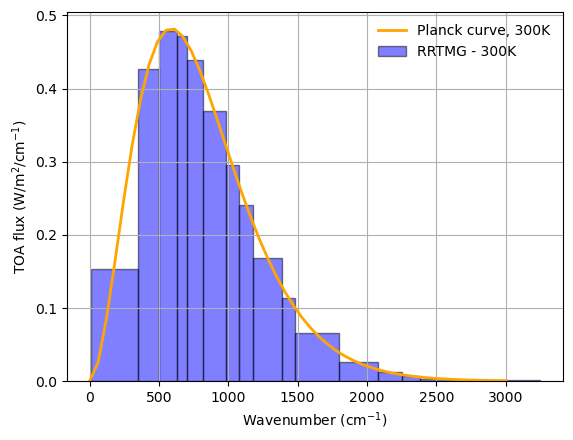

In [15]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100)

make_planck_curve(ax, 300, color='orange')
make_rrtmg_spectrum(ax, rad1.OLR_spectral, label='RRTMG - 300K')
ax.legend(frameon=False)

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")
ax.grid()

In [16]:
#  Same calculation as above but with some well-mixed CO2 in the column

rad2 = calc_olr(SST=300, CO2ppmv=10, RH=0., qStrat=0., return_spectral_olr=True, )
rad3 = calc_olr(SST=300, CO2ppmv=280, RH=0., qStrat=0., return_spectral_olr=True, )

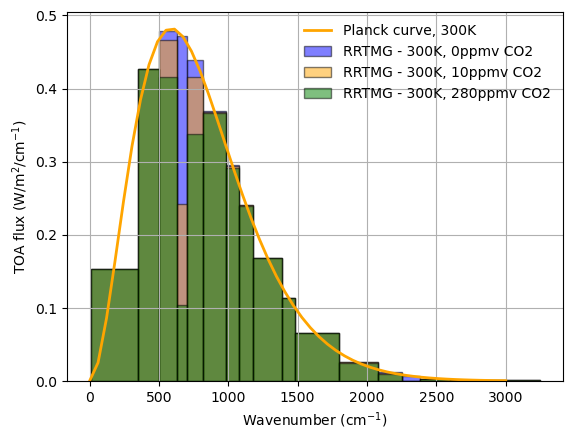

In [17]:
fig, ax = plt.subplots(dpi=100)

make_planck_curve(ax, 300, color='orange')
make_rrtmg_spectrum(ax, rad1.OLR_spectral, label='RRTMG - 300K, 0ppmv CO2', color='blue')
make_rrtmg_spectrum(ax, rad2.OLR_spectral, label='RRTMG - 300K, 10ppmv CO2', color='orange')
make_rrtmg_spectrum(ax, rad3.OLR_spectral, label='RRTMG - 300K, 280ppmv CO2', color='green')

ax.legend(frameon=False)

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")
ax.grid()


In [18]:
# Our calc_olr() function handles water vapor by setting the RH parameter

rad4 = calc_olr(SST=300, CO2ppmv=0., RH=0.8, return_spectral_olr=True, )

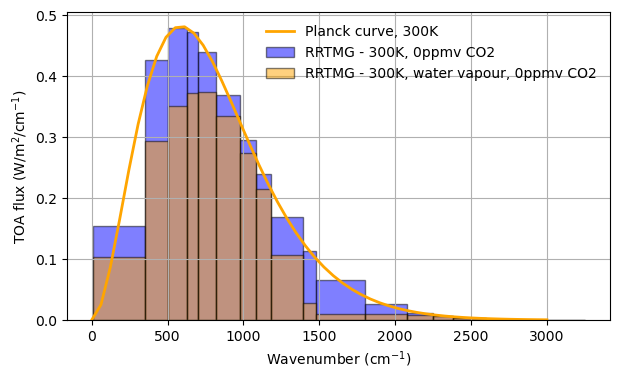

In [19]:
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

make_planck_curve(ax, 300, color='orange')
make_rrtmg_spectrum(ax, rad1.OLR_spectral, label="RRTMG - 300K, 0ppmv CO2", color='blue')
make_rrtmg_spectrum(ax, rad4.OLR_spectral, label="RRTMG - 300K, water vapour, 0ppmv CO2", color='orange')

ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")
ax.grid()

In [20]:
SSTcolors = {320: 'green',
             300: 'orange',
             280: 'blue',
            }

rad = {}
for SST in SSTcolors:
    rad[SST] = calc_olr(SST=SST, CO2ppmv=0., RH=0.8, return_spectral_olr=True, )

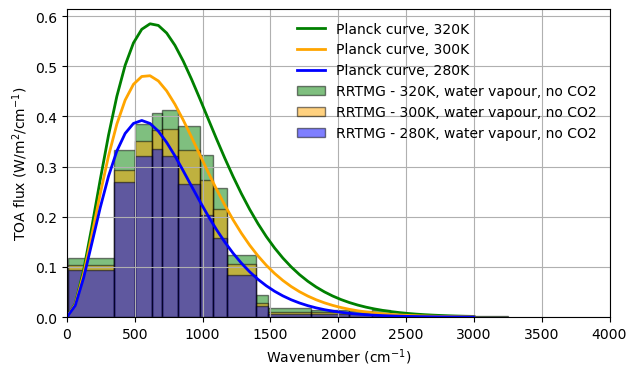

In [21]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

for SST in SSTcolors:
    make_planck_curve(ax, SST, color=SSTcolors[SST])
    make_rrtmg_spectrum(ax, rad[SST].OLR_spectral,
                        label="RRTMG - {}K, water vapour, no CO2".format(SST),
                        color=SSTcolors[SST])

ax.set_xlim(0, 4000)
ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")
ax.grid()

In [22]:
feedback = {}
for SST in SSTcolors:
    # Calculate perturbation (+1K) state diagnostics
    rad_p1 = calc_olr(SST=SST+1, CO2ppmv=0., RH=0.8, return_spectral_olr=True, )
    # Calculate spectral feedback parameter
    feedback[SST] = (rad_p1.OLR_spectral-rad[SST].OLR_spectral)

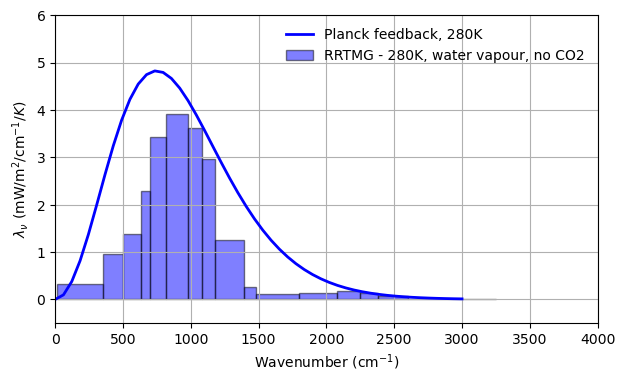

In [23]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

SST=280
make_planck_feedback(ax, SST, color=SSTcolors[SST])
make_rrtmg_spectrum(ax, feedback[SST]*1000,
                    label="RRTMG - {}K, water vapour, no CO2".format(SST),
                    color=SSTcolors[SST])

ax.set_xlim(0, 4000)

ax.set_ylim(-0.5, 6)
ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel(r"$\lambda_{\nu}$ (mW/m$^{2}$/cm$^{-1}/K$)")
ax.grid()


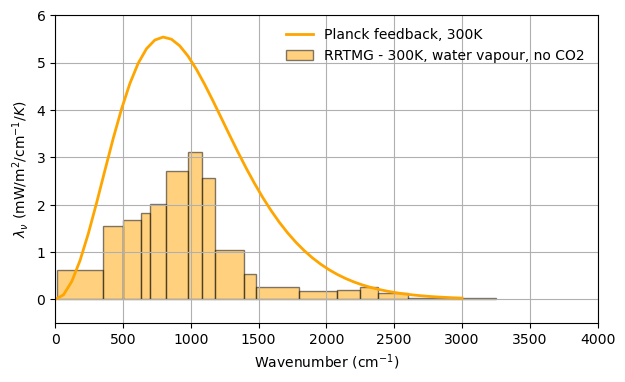

In [24]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

SST=300
make_planck_feedback(ax, SST, color=SSTcolors[SST])
make_rrtmg_spectrum(ax, feedback[SST]*1000,
                    label="RRTMG - {}K, water vapour, no CO2".format(SST),
                    color=SSTcolors[SST])

ax.set_xlim(0, 4000)
ax.set_ylim(-0.5, 6)
ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel(r"$\lambda_{\nu}$ (mW/m$^{2}$/cm$^{-1}/K$)")
ax.grid()

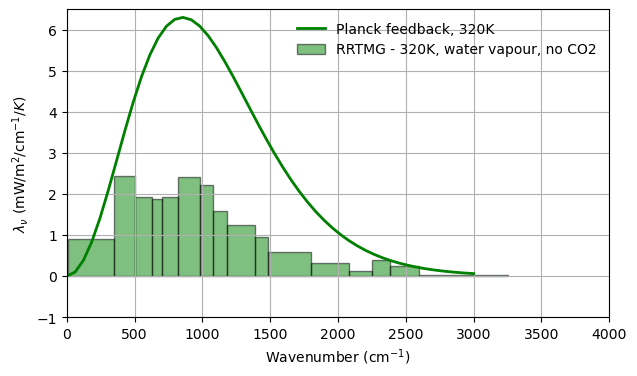

In [25]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

SST=320
make_planck_feedback(ax, SST, color=SSTcolors[SST])
make_rrtmg_spectrum(ax, feedback[SST]*1000,
                    label="RRTMG - {}K, water vapour, no CO2".format(SST),
                    color=SSTcolors[SST])

ax.set_xlim(0, 4000)
ax.set_ylim(-1, 6.5)
ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel(r"$\lambda_{\nu}$ (mW/m$^{2}$/cm$^{-1}/K$)")
ax.grid()